### Objetivo: criar um modelo de regressão linear que preveja o petal_width (y) das flores de acordo com as variáveis independentes (X).

#### 1º - Importar pacotes

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import statsmodels.api as sm # para estimar os betas
import scipy.stats as st #para o cálculo da correlação de pearson
from statsmodels.stats.outliers_influence import variance_inflation_factor #para cálculo do VIF


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#### 2º - Importar base de dados

In [108]:
iris = pd.read_csv('C:/Users/samar/Desktop/iris_dataset.csv')

In [109]:
iris

,id,sepal_length,sepal_width,petal_length,petal_width,species
0,1,5.138728,3.470118,1.441015,1.094873,setosa
1,2,4.849873,3.034931,1.414931,0.968687,setosa
2,3,4.715843,3.239083,1.295309,1.006643,setosa
3,4,4.603747,NaN,1.480616,1.002344,setosa
4,5,4.988744,3.645049,1.417527,1.122947,setosa
...,...,...,...,...,...,...
145,146,6.664208,2.994751,5.219754,3.061857,virginica
146,147,6.319889,2.453381,5.035004,2.536681,virginica
147,148,6.488279,2.989227,5.203232,2.749461,virginica
148,149,6.228777,3.371570,5.416274,3.153742,virginica


#### 3º - Verificar os tipos das colunas

In [110]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            150 non-null    int64  
 1   sepal_length  150 non-null    float64
 2   sepal_width   147 non-null    float64
 3   petal_length  150 non-null    float64
 4   petal_width   149 non-null    float64
 5   species       150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


#### 4º - Verificar a existência de NaNs

In [111]:
iris.isna().sum()

    # Obs.: existem valores nulos

id              0
sepal_length    0
sepal_width     3
petal_length    0
petal_width     1
species         0
dtype: int64

#### 5º - Filtrando os valores NaN

In [112]:
iris[(iris['sepal_width'].isnull())|(iris['petal_width'].isnull())]

,id,sepal_length,sepal_width,petal_length,petal_width,species
3,4,4.603747,NaN,1.480616,1.002344,setosa
53,54,5.442775,2.340928,4.027838,NaN,versicolor
61,62,5.879497,NaN,4.181942,2.259954,versicolor
100,101,6.230628,NaN,6.001908,3.321872,virginica


#### 6º - Coluna sepal_width: Fazer a mean imputation dos valores nulos, de acordo com a espécie

In [113]:
iris['sepal_width'] = iris.groupby('species')['sepal_width'].transform(lambda x: x.fillna(x.mean()))

    # Verificar se os valores nulos foram preenchidos

iris[iris['sepal_width'].isnull()]

,id,sepal_length,sepal_width,petal_length,petal_width,species


#### 7º - Coluna petal_width: Fazer a mean imputation dos valores nulos, de acordo com a espécie

In [114]:
iris['petal_width'] = iris.groupby('species')['petal_width'].transform(lambda x: x.fillna(x.mean()))

    # Verificar se os valores nulos foram preenchidos

iris[(iris['petal_width'].isnull())]

,id,sepal_length,sepal_width,petal_length,petal_width,species


#### 8º - Verificar se o df ainda tem valores NaN

In [115]:
iris.isna().sum()

id              0
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

#### 9º - Fazer o summary dos dados

In [116]:
iris.describe()

,id,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.837808,3.052765,3.754958,1.962049
std,43.445368,0.829649,0.438753,1.764346,0.728163
min,1.000000,4.270281,2.025099,1.012829,0.814850
25%,38.250000,5.112737,2.760439,1.551973,1.195078
50%,75.500000,5.765678,3.009792,4.342197,2.031770
75%,112.750000,6.411706,3.343547,5.078362,2.562366
max,150.000000,7.903810,4.394665,6.892382,3.391172


#### 10º - Remover a coluna id, pois é apenas um índice

In [117]:
iris = iris.drop(columns=['id'])
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.138728,3.470118,1.441015,1.094873,setosa
1,4.849873,3.034931,1.414931,0.968687,setosa
2,4.715843,3.239083,1.295309,1.006643,setosa
3,4.603747,3.434218,1.480616,1.002344,setosa
4,4.988744,3.645049,1.417527,1.122947,setosa
...,...,...,...,...,...
145,6.664208,2.994751,5.219754,3.061857,virginica
146,6.319889,2.453381,5.035004,2.536681,virginica
147,6.488279,2.989227,5.203232,2.749461,virginica
148,6.228777,3.371570,5.416274,3.153742,virginica


#### 11º - Transformar a coluna species em dummy, pois é uma categoria

In [118]:
    # Fazer os dummies

species_one_hot = pd.get_dummies(iris.species)

    # Colocar as colunas dummies no data frame
    
iris = iris.join(species_one_hot)

    # Remover a coluna original species
    
iris = iris.drop('species', axis =1)
iris

,sepal_length,sepal_width,petal_length,petal_width,setosa,versicolor,virginica
0,5.138728,3.470118,1.441015,1.094873,1,0,0
1,4.849873,3.034931,1.414931,0.968687,1,0,0
2,4.715843,3.239083,1.295309,1.006643,1,0,0
3,4.603747,3.434218,1.480616,1.002344,1,0,0
4,4.988744,3.645049,1.417527,1.122947,1,0,0
...,...,...,...,...,...,...,...
145,6.664208,2.994751,5.219754,3.061857,0,0,1
146,6.319889,2.453381,5.035004,2.536681,0,0,1
147,6.488279,2.989227,5.203232,2.749461,0,0,1
148,6.228777,3.371570,5.416274,3.153742,0,0,1


#### 12º - Definir as variáveis

In [119]:
y = iris['petal_width'] #yi, valores observados da variável dependentes Y
X = iris[['petal_length','sepal_length', 'sepal_width',
          'setosa', 'versicolor', 'virginica']] #xi, valores observados das variáveis independentes X

#### 13º - Fazer a reescala de X, através de Min Max

In [120]:
    # Refazer a escala (de 0 a 1)
    
scaler = MinMaxScaler(feature_range = (0,1))

    # Transformar o X de acordo com a nova escala
    
rescaledX = scaler.fit_transform(X)

    # Atribuir os novos valores de X como dataframe ao X
        
X = pd.DataFrame(rescaledX, columns = X.columns)

    # Data frame X reescalado

X.describe()

,petal_length,sepal_length,sepal_width,setosa,versicolor,virginica
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.466384,0.431406,0.433694,0.333333,0.333333,0.333333
std,0.300082,0.228332,0.185162,0.472984,0.472984,0.472984
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.091698,0.231856,0.310327,0.000000,0.000000,0.000000
50%,0.566262,0.411555,0.415558,0.000000,0.000000,0.000000
75%,0.691470,0.589351,0.556409,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 14º - Adicionar a constante (beta 0) ao data frame

In [121]:
X = sm.add_constant(X)
X

,const,petal_length,sepal_length,sepal_width,setosa,versicolor,virginica
0,1.0,0.072826,0.239009,0.609824,1.0,0.0,0.0
1,1.0,0.068390,0.159512,0.426167,1.0,0.0,0.0
2,1.0,0.048044,0.122625,0.512323,1.0,0.0,0.0
3,1.0,0.079562,0.091775,0.594674,1.0,0.0,0.0
4,1.0,0.068831,0.197731,0.683649,1.0,0.0,0.0
...,...,...,...,...,...,...,...
145,1.0,0.715518,0.658844,0.409211,0.0,0.0,1.0
146,1.0,0.684095,0.564082,0.180743,0.0,0.0,1.0
147,1.0,0.712708,0.610425,0.406879,0.0,0.0,1.0
148,1.0,0.748942,0.539007,0.568235,0.0,0.0,1.0


#### 15º - Fazer o MQO

In [122]:
model = sm.OLS(y,X)
results = model.fit() 

#### 16º - Teste de hipóteses para verificar se as variáveis são significativas

In [123]:
results.summary() # resumo do MQO

    # H0: Beta j = 0 => o parâmetro beta é igual a 0 estatisticamente, ou seja, não é significativo
    # H1: Beta j ≠ 0 => o parâmetro beta não é igual a 0 estatisticamente, ou seja, é significativo
    
    # Conclusão do teste de hipóteses:
        # Quando o p-valor é maior do que alfa (5%), a hipótese nula não é rejeitada. Logo, sepal_length não é significativa e deve ser retirada do modelo

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            petal_width   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     505.5
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           2.06e-89
Time:                        19:58:23   Log-Likelihood:                 54.289
No. Observations:                 150   AIC:                            -96.58
Df Residuals:                     144   BIC:                            -78.51
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.7012      0.077      9.106      0.000       0.549       0.853
petal_length     1.4554      0.295      4.935      0.000       0.872       2.038
sepal_length    -0.3254      0.166     -1.957      0.052      -0.654       0.003
sepal_width      1.1269      0.118      9.558      0.000       0.894       1.360
setosa          -0.3139      0.080     -3.945      0.000      -0.471      -0.157
versicolor       0.3127      0.051      6.122      0.000       0.212       0.414
virginica        0.7024      0.096      7.313      0.000       0.513       0.892
==============================================================================
Omnibus:                        5.434   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                7.525
Skew:                          -0.127   Prob(JB):                       0.0232
Kurtosis:                       4.067   Cond. No.                     5.85e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.57e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### 17º - Fazer a matriz de correlação das variáveis

<AxesSubplot:>

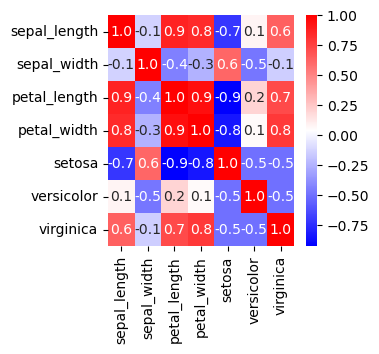

In [124]:
    # Fazer a correlação
    
correl_matrix = iris.corr()

    # Criar a figura. Obs.: não é necessário, mas fiz pq queria a figura maior
    
plt.figure(figsize=(3,3))
    
    # Criar o heatmap.
        # Obs.: annot = informação na célula, fmt = formato do nº, cmap = paleta de cores
        
sns.heatmap(correl_matrix, annot = True, fmt=".1f", cmap = 'bwr')

    # Conclusão => tem correlações fortes positivas e negativas

#### 18º - Fazer o VIF das variáveis explicativas

In [125]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

    # Conclusão:
        # Petal_length deve ser removido pois seu VIF é maior do que 10, o que significa que a colinearidade é significativamente forte
        # Setosa, versicolor e virginica possuem VIFs infinitos, o que significa correlação perfeita
            # Será removido uma dessas variáveis, e verificado se melhora a multicolinearidade

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,variable
0,0.000000,const
1,39.463740,petal_length
2,7.260945,sepal_length
3,2.401291,sepal_width
4,inf,setosa
5,inf,versicolor
6,inf,virginica


#### 19º - Remover as variáveis abaixo:

In [126]:
    # sepal_length, pois não é significativa
    # petal_length, pois tem VIF maior do que 10
    # setosa, pois ela é a espécie que possui correlação com mais variáveis


X = X.drop(['sepal_length','petal_length','setosa'], axis=1)
X

,const,sepal_width,versicolor,virginica
0,1.0,0.609824,0.0,0.0
1,1.0,0.426167,0.0,0.0
2,1.0,0.512323,0.0,0.0
3,1.0,0.594674,0.0,0.0
4,1.0,0.683649,0.0,0.0
...,...,...,...,...
145,1.0,0.409211,0.0,1.0
146,1.0,0.180743,0.0,1.0
147,1.0,0.406879,0.0,1.0
148,1.0,0.568235,0.0,1.0


#### 20º - Fazer um novo MQO

In [127]:
model = sm.OLS(y,X)
results = model.fit()

#### 21º - Teste de hipóteses para verificar se as variáveis são significativas

In [128]:
results.summary() # resumo do MQO

    # H0: Beta j = 0 => o parâmetro beta é igual a 0 estatisticamente, ou seja, não é significativo
    # H1: Beta j ≠ 0 => o parâmetro beta não é igual a 0 estatisticamente, ou seja, é significativo
    
    # Conclusão do teste de hipóteses: as variáveis são significativas, porque o p-valor não é maior que alfa de 5%

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            petal_width   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     702.7
Date:                Sat, 11 Mar 2023   Prob (F-statistic):           1.60e-86
Time:                        19:58:24   Log-Likelihood:                 40.511
No. Observations:                 150   AIC:                            -73.02
Df Residuals:                     146   BIC:                            -60.98
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3665      0.070      5.259      0.000       0.229       0.504
sepal_width     1.2381      0.108     11.421      0.000       1.024       1.452
versicolor      1.2674      0.048     26.139      0.000       1.172       1.363
virginica       1.9083      0.043     44.174      0.000       1.823       1.994
==============================================================================
Omnibus:                        1.824   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.402   Jarque-Bera (JB):                1.424
Skew:                           0.114   Prob(JB):                        0.491
Kurtosis:                       3.419   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 22º - Fazer uma matriz de correlação das variáveis

<AxesSubplot:>

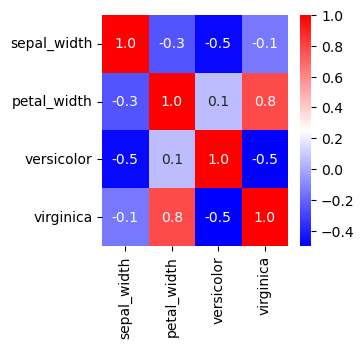

In [129]:
    # Remover as variáveis do modelo
iris = iris.drop(['sepal_length','petal_length','setosa'], axis = 1)

    # Fazer a correlação
    
correl_matrix = iris.corr()

    # Criar a figura. Obs.: não é necessário, mas fiz pq queria a figura maior
    
plt.figure(figsize=(3,3))
    
    # Criar o heatmap.
        # Obs.: annot = informação na célula, fmt = formato do nº, cmap = paleta de cores
        
sns.heatmap(correl_matrix, annot = True, fmt=".1f", cmap = 'bwr')

    # Conclusão => as correlações diminuíram

#### 23º - Fazer o novo VIF das variáveis explicativas

In [130]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

    # Conclusão: a multicolinearidade não é significativa, pois o VIF é menor que 0

,VIF,variable
0,20.785829,const
1,1.712833,sepal_width
2,2.235919,versicolor
3,1.774867,virginica


#### 24º - Separar os dados para teste e treino

In [131]:
test_size = 0.33    # 1/3 da amostra será usado para verrificar a precisão do modelo

seed = 1    # Controle do shuffling dos dados antes da separação entre teste e treino

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed)

#### 25º - Regressão linear - Criar e treinar o modelo

In [132]:


    # Criar um modelo com o algoritmo
    
model = LinearRegression()

    # Treinar o modelo, com as respostas corretas

model.fit(X_train, y_train)

LinearRegression()

#### 26º - Regressão linear - Checar o desempenho do modelo com as informações de treino

In [133]:
    # Descobrindo os valores de y train, através de X train
        
predictions_train = model.predict(X_train)

    # Erro médio absoluto (mean absolute error)
    
mae_lr_train = mean_absolute_error(y_train, predictions_train)

    # R²

r2_train = r2_score(y_train, predictions_train)

#### 27º - Regressão linear - Avaliar o modelo com as informações de teste

In [134]:
    # Descobrindo os valores de y test, através dos valores de X test
        
predictions_test = model.predict(X_test) 

    # Erro médio absoluto (mean absolute error)
    
mae_lr_test = mean_absolute_error(y_test, predictions_test)

    # R²

r2_test = r2_score(y_test, predictions_test)

#### 28º - Conclusões

In [135]:
print(f'Regressão Linear: O erro médio absoluto do modelo com as informações de treino é {mae_lr_train}.\n'
      + f'Regressão Linear: O erro médio absoluto do modelo com as informações de teste é {mae_lr_test}.\n'
      + f'O EMA de teste está perto de 0, logo o modelo tem poucos erros.')

print('____________________________________________________________________________________________________\n')

print(f'Regressão Linear: O r² do modelo com as informações de treino é {r2_train}.\n'
      + f'Regressão Linear: O r² do modelo com as informações de teste é {r2_test}.\n'
      + f'O r² de teste está perto de 1, logo o modelo explica bem os dados.')

Regressão Linear: O erro médio absoluto do modelo com as informações de treino é 0.14683400722542336.
Regressão Linear: O erro médio absoluto do modelo com as informações de teste é 0.12921196572002336.
O EMA de teste está perto de 0, logo o modelo tem poucos erros.
____________________________________________________________________________________________________

Regressão Linear: O r² do modelo com as informações de treino é 0.9335082248873362.
Regressão Linear: O r² do modelo com as informações de teste é 0.9376134976538161.
O r² de teste está perto de 1, logo o modelo explica bem os dados.
